# Required Libraries

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn_pandas import DataFrameMapper, gen_features
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder, PolynomialFeatures, MinMaxScaler, QuantileTransformer
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, StratifiedKFold, TimeSeriesSplit, cross_val_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.multioutput import RegressorChain
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

from hyperopt import hp, tpe
from hyperopt.fmin import fmin

In [ ]:
!pip install bds_courseware
from bds_courseware import read_drive_dataset
from bds_courseware import HOMEWORK_DATASETS

name = "bike_sharing_hour"
df = read_drive_dataset(*HOMEWORK_DATASETS[name])

# Data Overview

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [ ]:
df['dteday'] = pd.to_datetime(df['dteday'])

In [ ]:
df

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


In [ ]:
df.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


Let's outline numerical and categorical data.

In [ ]:
supportive = ['instant', 'dteday']
categorical = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit']
numerical = ['temp', 'atemp', 'hum', 'windspeed']
target_decompos = ['casual', 'registered']
target = 'cnt'

In [ ]:
for cat in categorical:
  df[cat] = df[cat].astype('category')

In [ ]:
df[categorical + numerical]

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
17374,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642
17375,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642
17376,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642
17377,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343


# EDA

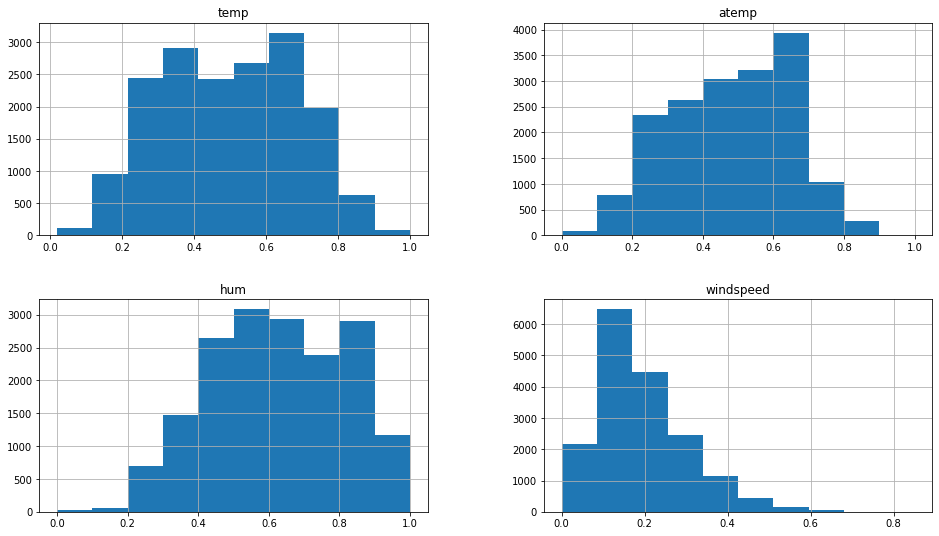

In [ ]:
df[numerical].hist(figsize=(16, 9));

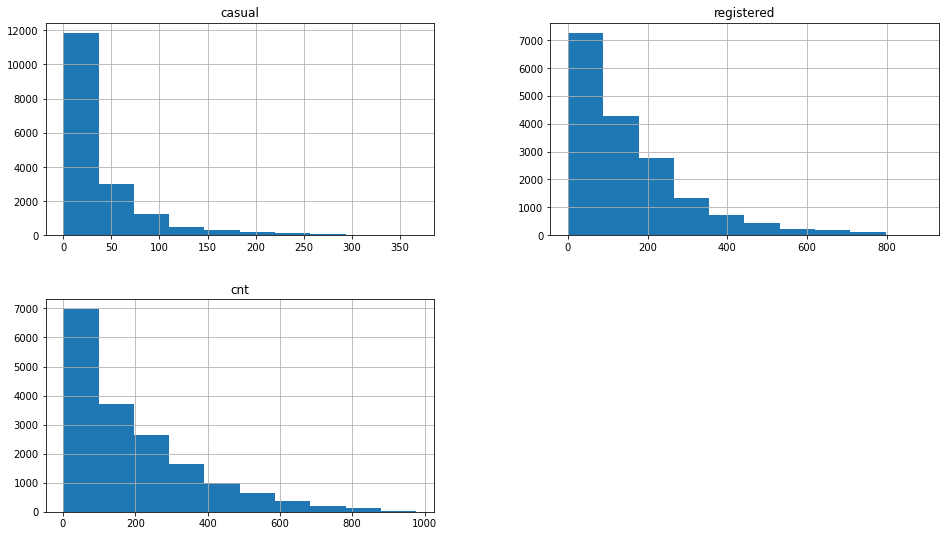

In [ ]:
df[target_decompos + [target]].hist(figsize=(16, 9));

We can see, that 3 targets do not distributed like normal. 'cnt' consists of 2 features. Probably, we should investigate relations between them and predictors separetly.

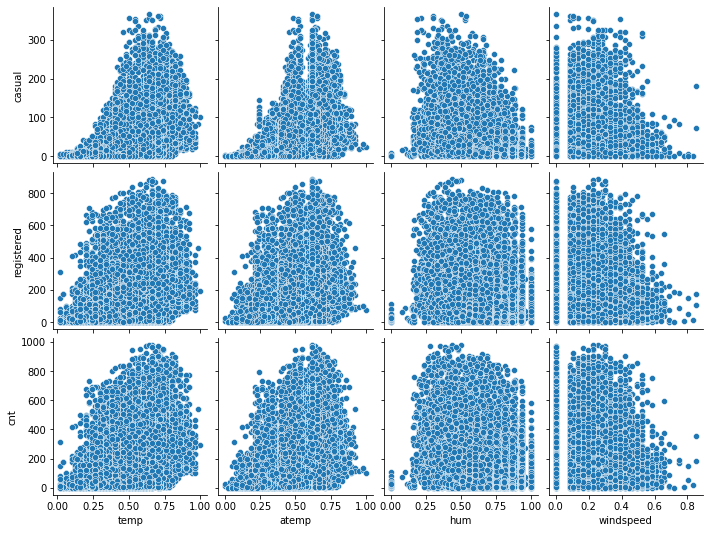

In [ ]:
sns.pairplot(df, x_vars=numerical, y_vars=['casual', 'registered', 'cnt']);

We can see other patterns for casual in comparison to main cnt and registered. Let's also look at the relationship between all numerical data using correlation coefficients.

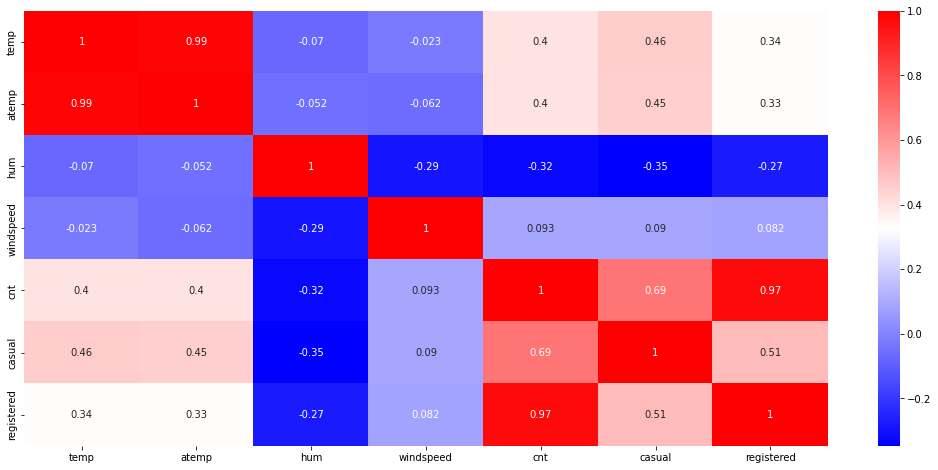

In [ ]:
plt.figure(figsize=(18,8))
sns.heatmap(df[numerical + [target] + target_decompos].corr(),cmap='bwr',annot=True);

We can see, that the relation between cnt and registered is stronger than between casual and cnt. Probably, registered make more impact on the main target. 

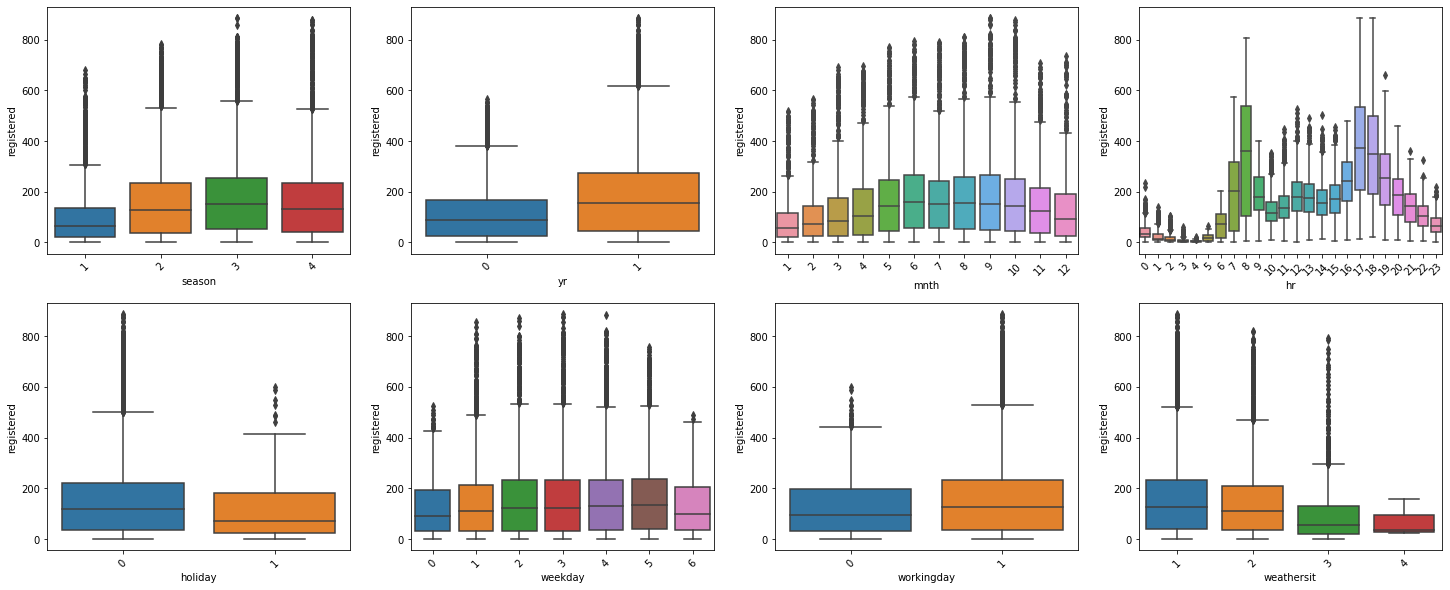

In [ ]:
def plot_boxplots(target='registered'):

  categorical_len = len(categorical)
  cols_num = 4

  fig, axes = plt.subplots(int(np.ceil(categorical_len / cols_num)) , cols_num,
                          sharex=False, figsize=(25, 5 * categorical_len // cols_num))

  for ax in fig.axes:
      plt.sca(ax)
      plt.xticks(rotation=45)

  for i, feature in enumerate(categorical):
      sns.boxplot(ax=axes[i // cols_num, i % cols_num], x=df[feature] , y=df[target]);

plot_boxplots()

Some insights:
* Features mnth, hr, weekday and weathersit show some noticable patterns in registered.

* We can see the difference in registered for data, divided by year. We have time series data, so it can affect the results, if wee train models in an appropriate way (using cross val and data split for time series). Probably this trend will be the same for other targets.

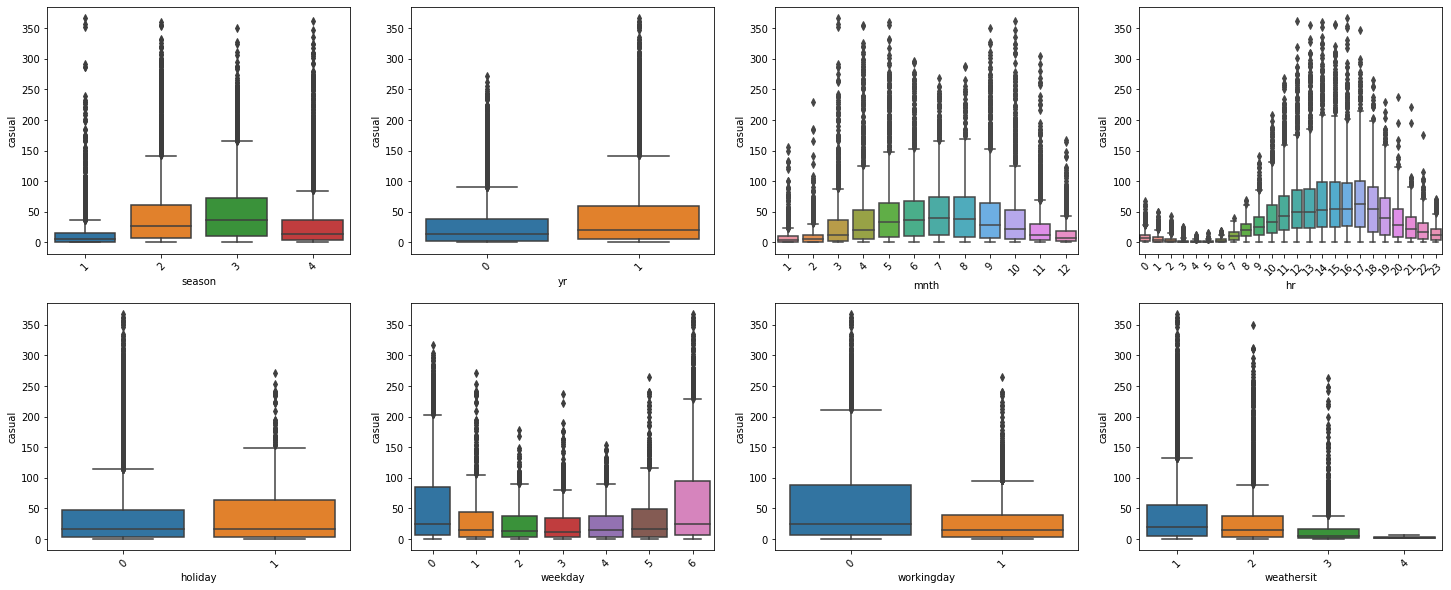

In [ ]:
plot_boxplots('casual')

Some insights:
* The graphs for casual are little different than for regidtered. We can see it clearly for mnth, weekday, workingday and hr.

We can see difference in relationship of casual and registered with categorical data. So, we can try to sepatretly predict casual and registered in order to improve our results.

Now let's analyze behavior of cnt in time.

In [ ]:
def plotMovingAverage(dataset, n, conf=True):

    """
    dataset - dataframe with timeseries
    n - rolling window size 

    """
    # calculate rolling mean
    df = pd.DataFrame()
    df['Date'] = dataset['dteday']
    df['y'] = dataset['cnt']
    df['roll_mean'] = df['y'].rolling(window=n).mean()

    # calculate confidence interval
    if conf:
      rolling_std =  df['y'].rolling(window=n).std()
      df['upper'] = df['roll_mean']+1.96*rolling_std
      #df['lower'] = df['roll_mean']-1.96*rolling_std

    df = df.iloc[n:]
    plt.figure(figsize=(20, 10))

    plt.plot(df.Date, df.y, label="cnt", alpha=0.3)
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(df.Date, df.roll_mean, "g", label="Rolling mean trend(cnt)")
    if conf:
      plt.plot(df.Date, df.upper, "r--", label="Upper bound / Lower bound")
      #plt.plot(df.Date, df.lower, "r--")
    

    plt.legend(loc="upper left")
    plt.grid(True)

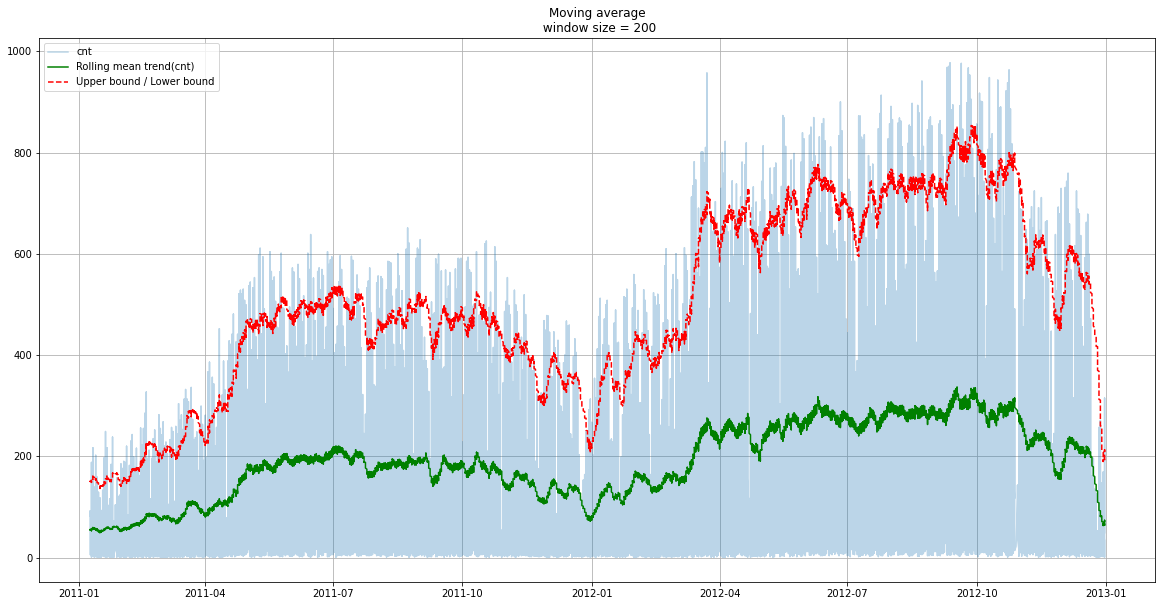

In [ ]:
plotMovingAverage(df, 200)

It can be clearly seen, that cnt is higher for the second year. If we train our model on 2011 and validate on 2012, we can get biased predictions.

# Data Preparation

Most of our algorithm can deal with non-linearity and do not require any pre-processing. But not all, so we need to perform some data transformations. 

In [ ]:
class IdentityTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, input_array, y=None):
        return self
    
    def transform(self, input_array, y=None):
        return input_array


numerical_def = gen_features(
    columns=[[c] for c in numerical],
    classes=[
        {'class': MinMaxScaler}
    ],
)

cat_def = gen_features(
    columns=[[c] for c in categorical],
    classes=[
        {'class': OneHotEncoder}
    ],
)

In [ ]:
features = numerical_def + cat_def
mapper = DataFrameMapper(features, df_out=True)

In [ ]:
mapper.features

[(['temp'], [MinMaxScaler(copy=True, feature_range=(0, 1))]),
 (['atemp'], [MinMaxScaler(copy=True, feature_range=(0, 1))]),
 (['hum'], [MinMaxScaler(copy=True, feature_range=(0, 1))]),
 (['windspeed'], [MinMaxScaler(copy=True, feature_range=(0, 1))]),
 (['season'],
  [OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
                 handle_unknown='error', sparse=True)]),
 (['yr'],
  [OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
                 handle_unknown='error', sparse=True)]),
 (['mnth'],
  [OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
                 handle_unknown='error', sparse=True)]),
 (['hr'],
  [OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
                 handle_unknown='error', sparse=True)]),
 (['holiday'],
  [OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
                 handle_unknown='error', sparse=True)]),
 (['weekday

# Training Models

In [ ]:
X  = df[categorical + numerical]
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      17379 non-null  category
 1   yr          17379 non-null  category
 2   mnth        17379 non-null  category
 3   hr          17379 non-null  category
 4   holiday     17379 non-null  category
 5   weekday     17379 non-null  category
 6   workingday  17379 non-null  category
 7   weathersit  17379 non-null  category
 8   temp        17379 non-null  float64 
 9   atemp       17379 non-null  float64 
 10  hum         17379 non-null  float64 
 11  windspeed   17379 non-null  float64 
dtypes: category(8), float64(4)
memory usage: 681.2 KB


In [ ]:
X_train , X_test, y_train_decomp, y_test_decomp = train_test_split(X, df[target_decompos + [target]], test_size=0.15, shuffle=True, random_state=42)

X_train = mapper.fit_transform(X_train)
X_test = mapper.transform(X_test)

y_train_decomp, y_train = y_train_decomp.iloc[:, :2], y_train_decomp.iloc[:, 2]
y_test_decomp, y_test = y_test_decomp.iloc[:, :2], y_test_decomp.iloc[:, 2]

In [ ]:
X_train

,temp,atemp,hum,windspeed,season_x0_1,season_x0_2,season_x0_3,season_x0_4,yr_x0_0,yr_x0_1,mnth_x0_1,mnth_x0_2,mnth_x0_3,mnth_x0_4,mnth_x0_5,mnth_x0_6,mnth_x0_7,mnth_x0_8,mnth_x0_9,mnth_x0_10,mnth_x0_11,mnth_x0_12,hr_x0_0,hr_x0_1,hr_x0_2,hr_x0_3,hr_x0_4,hr_x0_5,hr_x0_6,hr_x0_7,hr_x0_8,hr_x0_9,hr_x0_10,hr_x0_11,hr_x0_12,hr_x0_13,hr_x0_14,hr_x0_15,hr_x0_16,hr_x0_17,hr_x0_18,hr_x0_19,hr_x0_20,hr_x0_21,hr_x0_22,hr_x0_23,holiday_x0_0,holiday_x0_1,weekday_x0_0,weekday_x0_1,weekday_x0_2,weekday_x0_3,weekday_x0_4,weekday_x0_5,weekday_x0_6,workingday_x0_0,workingday_x0_1,weathersit_x0_1,weathersit_x0_2,weathersit_x0_3,weathersit_x0_4
7712,0.469388,0.4697,0.94,0.298225,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
5426,0.673469,0.6364,0.69,0.228047,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
15369,0.428571,0.4394,0.67,0.000000,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
16279,0.285714,0.3182,0.65,0.105325,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
8762,0.244898,0.2576,0.60,0.193018,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,0.448980,0.4545,0.88,0.105325,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
11964,0.653061,0.6212,0.34,0.157870,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
5390,0.795918,0.7273,0.43,0.333373,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
860,0.224490,0.1970,0.65,0.491243,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


## SVR

In [ ]:
svr_reg_params ={
    'C' : hp.choice('C', [0.01, 0.1, 0.5, 1, 5, 10, 50, 100, 300, 1000]),
    'gamma' : hp.choice('gamma', ['scale', 'auto']),
    'kernel' : hp.choice('kernel', ['linear', 'poly', 'rbf']),
    'epsilon' :  hp.quniform('epsilon', 0.001, 0.5, 0.001),
}
cv = KFold(n_splits=3)

def hyperopt_svr_score(params):
    reg = SVR(**params)
    current_score = cross_val_score(reg, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1, ).mean()
    print(current_score, params)
    return -current_score
 

svr_best = fmin(fn=hyperopt_svr_score, space=svr_reg_params, algo=tpe.suggest, max_evals=50)
print('best:')
print(svr_best)

-116.61396744482487
{'C': 0.5, 'epsilon': 0.382, 'gamma': 'scale', 'kernel': 'rbf'}
-28.573202669538517
{'C': 300, 'epsilon': 0.113, 'gamma': 'scale', 'kernel': 'rbf'}
-64.4465859064335
{'C': 100, 'epsilon': 0.041, 'gamma': 'auto', 'kernel': 'rbf'}
-137.10145513224518
{'C': 0.01, 'epsilon': 0.201, 'gamma': 'scale', 'kernel': 'poly'}
-31.256102410818
{'C': 100, 'epsilon': 0.438, 'gamma': 'scale', 'kernel': 'rbf'}
-131.0527757019387
{'C': 0.01, 'epsilon': 0.008, 'gamma': 'scale', 'kernel': 'linear'}
-121.58311550727298
{'C': 1, 'epsilon': 0.269, 'gamma': 'auto', 'kernel': 'rbf'}
-90.39604642909717
{'C': 1, 'epsilon': 0.266, 'gamma': 'scale', 'kernel': 'poly'}
-129.19253855166315
{'C': 50, 'epsilon': 0.224, 'gamma': 'auto', 'kernel': 'poly'}
-30.10252642115958
{'C': 1000, 'epsilon': 0.266, 'gamma': 'scale', 'kernel': 'poly'}
-64.4461561672539
{'C': 100, 'epsilon': 0.094, 'gamma': 'auto', 'kernel': 'rbf'}
-80.62839749683131
{'C': 0.5, 'epsilon': 0.273, 'gamma': 'scale', 'kernel': 'linear'}

In [ ]:
reg = SVR(**{'C': 300, 'epsilon': 0.498, 'gamma': 'scale', 'kernel': 'rbf'})
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)  
svr_mae = mean_absolute_error(y_test, y_pred)
svr_r2 = r2_score(y_test, y_pred)
print('MAE: ', svr_mae)
print('R2: ', svr_r2)

MAE:  26.45630126417376
R2:  0.9380766317037821


## KNN Regressor 

In [ ]:
knn_reg_params ={
    'n_neighbors' : hp.choice('n_neighbors', np.arange(1, 200)),
    'weights' : hp.choice('weights', ['uniform', 'distance']),
    'p' : hp.choice('p',  [1, 2, 3])
}
cv = KFold(n_splits=3)

def hyperopt_knn_score(params):
    reg = KNeighborsRegressor(**params)
    current_score = cross_val_score(reg, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1).mean()
    print(current_score, params)
    return -current_score
 

knn_best = fmin(fn=hyperopt_knn_score, space=knn_reg_params, algo=tpe.suggest, max_evals=50)
print('best:')
print(knn_best)

-97.0983900595218
{'n_neighbors': 149, 'p': 1, 'weights': 'distance'}
-103.22999740990593
{'n_neighbors': 161, 'p': 3, 'weights': 'uniform'}
-88.31910230291066
{'n_neighbors': 41, 'p': 3, 'weights': 'distance'}
-98.81490509620039
{'n_neighbors': 152, 'p': 2, 'weights': 'distance'}
-98.33526717212744
{'n_neighbors': 60, 'p': 2, 'weights': 'uniform'}
-104.8313368668238
{'n_neighbors': 183, 'p': 3, 'weights': 'uniform'}
-94.79312539332953
{'n_neighbors': 117, 'p': 1, 'weights': 'distance'}
-97.72701740213911
{'n_neighbors': 136, 'p': 2, 'weights': 'distance'}
-98.17533097343659
{'n_neighbors': 163, 'p': 1, 'weights': 'distance'}
-100.14446311767614
{'n_neighbors': 109, 'p': 1, 'weights': 'uniform'}
-101.90972023584779
{'n_neighbors': 142, 'p': 2, 'weights': 'uniform'}
-104.60113615849805
{'n_neighbors': 180, 'p': 3, 'weights': 'uniform'}
-96.66170045719316
{'n_neighbors': 114, 'p': 3, 'weights': 'distance'}
-84.21198889791498
{'n_neighbors': 18, 'p': 3, 'weights': 'uniform'}
-100.07089621

In [ ]:
reg = KNeighborsRegressor(**{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'})
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
knn_mae = mean_absolute_error(y_test, y_pred)
knn_r2 = r2_score(y_test, y_pred)
print('MAE: ', knn_mae)
print('R2: ', knn_r2)

MAE:  59.12313003452244
R2:  0.7342057238434442


## Decision Tree Regressor 

Experiments showed, that one hot encoding do not significanly improve the results of three based algorithms. So, we will use unprepared data for them. 

In [ ]:
X_train , X_test, y_train_decomp, y_test_decomp = train_test_split(X, df[target_decompos + [target]], test_size=0.2, shuffle=True, random_state=42)
y_train_decomp, y_train = y_train_decomp.iloc[:, :2], y_train_decomp.iloc[:, 2]
y_test_decomp, y_test = y_test_decomp.iloc[:, :2], y_test_decomp.iloc[:, 2]

In [ ]:
dtr_reg_params ={
    'criterion' : 'mae',
    'splitter' : hp.choice('splitter', ['best', 'random']),
    'max_depth' : hp.choice('max_depth',[1,3,5,7,9,11,12, 20, 40, 50]),
    'min_samples_split' : hp.choice('min_samples_split', [2,3,4,5,6,7,8,9,10]),
    'max_features' : hp.choice('max_features', ["auto","sqrt"]),
    'max_leaf_nodes' : hp.choice('max_leaf_nodes', [None,10,20,30,40,50,60,70,80,90])
}
cv = KFold(n_splits=3)

def hyperopt_dtr_score(params):
    reg = DecisionTreeRegressor(**params)
    current_score = cross_val_score(reg, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1).mean()
    print(current_score, params)
    return -current_score
 

dtr_best = fmin(fn=hyperopt_dtr_score, space=dtr_reg_params, algo=tpe.suggest, max_evals=50)
print('best:')
print(dtr_best)

-125.28158219417567
{'criterion': 'mae', 'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_samples_split': 9, 'splitter': 'random'}
-102.36841283187896
{'criterion': 'mae', 'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes': 90, 'min_samples_split': 5, 'splitter': 'random'}
-98.75582172759012
{'criterion': 'mae', 'max_depth': 50, 'max_features': 'sqrt', 'max_leaf_nodes': 50, 'min_samples_split': 10, 'splitter': 'random'}
-83.99671094952384
{'criterion': 'mae', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': 70, 'min_samples_split': 10, 'splitter': 'best'}
-108.19949841524358
{'criterion': 'mae', 'max_depth': 50, 'max_features': 'sqrt', 'max_leaf_nodes': 20, 'min_samples_split': 4, 'splitter': 'random'}
-61.95330976102249
{'criterion': 'mae', 'max_depth': 50, 'max_features': 'auto', 'max_leaf_nodes': 90, 'min_samples_split': 6, 'splitter': 'random'}
-46.797412508611295
{'criterion': 'mae', 'max_depth': 50, 'max_features': 'auto', 'max_leaf_nodes': 80,

In [ ]:
reg = DecisionTreeRegressor(**{'criterion': 'mae', 'max_depth': 50, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_split': 6, 'splitter': 'best'})
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
dtr_mae = mean_absolute_error(y_test, y_pred)
dtr_r2 = r2_score(y_test, y_pred)
print('MAE: ', dtr_mae)
print('R2: ', dtr_r2)

MAE:  33.84608745684695
R2:  0.8964338448870633


## Random Forest Regressor

In [ ]:
rfr_reg_params ={
  'bootstrap': hp.choice('bootstrap' ,[True, False]),
  'max_depth': hp.choice('max_depth' , [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]),
  'max_features': hp.choice('max_features' ,['auto', 'sqrt']),
  'min_samples_leaf': hp.choice('min_samples_leaf' ,[1, 2, 4]),
  'min_samples_split': hp.choice('min_samples_split' ,[2, 5, 10]),
  'n_estimators': hp.choice('n_estimators' , np.arange(20, 500))
}

cv = KFold(n_splits=3)

def hyperopt_rfr_score(params):
    reg = RandomForestRegressor(**params, n_jobs=-1)
    current_score = cross_val_score(reg, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error').mean()
    print(current_score, params)
    return -current_score
 

rfr_best = fmin(fn=hyperopt_rfr_score, space=rfr_reg_params, algo=tpe.suggest, max_evals=50)
print('best:')
print(rfr_best)


-44.171400169430036
{'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 159}
-41.0689116997706
{'bootstrap': False, 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 107}
-41.80820163353079
{'bootstrap': True, 'max_depth': 70, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 216}
-43.5097434444886
{'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 38}
-49.10913696282179
{'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 389}
-39.36186649941218
{'bootstrap': False, 'max_depth': 70, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 489}
-33.962080535841494
{'bootstrap': False, 'max_depth': 90, 'max_features': 'auto', 'min_samples_leaf': 4, '

In [ ]:
reg = RandomForestRegressor(**{'bootstrap': True, 'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 392})
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
rfr_mae = mean_absolute_error(y_test, y_pred)
rfr_r2 = r2_score(y_test, y_pred)
print('MAE: ', rfr_mae)
print('R2: ', rfr_r2)

MAE:  24.69883278495576
R2:  0.945153332823478


## LGBMRegressor (boosting)

In [ ]:
lgb_reg_params ={
    'num_leaves' : hp.choice('num_leaves', np.arange(2, 40, dtype=int)),
    'n_estimators' : hp.choice('n_estimators', range(50, 3000, 50)),
    'boosting_type' :  hp.choice('boosting_type', ['dart', 'gbdt']),
    'learning_rate' :  hp.quniform('learning_rate', 0.0001, 0.5, 0.0001),
}
cv = KFold(n_splits=3)

def hyperopt_lgbm_score(params):
    reg = LGBMRegressor(**params)
    current_score = cross_val_score(reg, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1).mean()
    print(current_score, params)
    return -current_score
 

lgb_best = fmin(fn=hyperopt_lgbm_score, space=lgb_reg_params, algo=tpe.suggest, max_evals=60)
print('best:')
print(lgb_best)

-24.888127749740892
{'boosting_type': 'dart', 'learning_rate': 0.4258, 'n_estimators': 2850, 'num_leaves': 23}
-30.663180950660138
{'boosting_type': 'gbdt', 'learning_rate': 0.38, 'n_estimators': 2850, 'num_leaves': 9}
-26.118070341357594
{'boosting_type': 'dart', 'learning_rate': 0.4801, 'n_estimators': 150, 'num_leaves': 35}
-30.789587843417134
{'boosting_type': 'gbdt', 'learning_rate': 0.37560000000000004, 'n_estimators': 800, 'num_leaves': 37}
-27.046509698790643
{'boosting_type': 'dart', 'learning_rate': 0.0308, 'n_estimators': 2400, 'num_leaves': 14}
-29.996551903662915
{'boosting_type': 'gbdt', 'learning_rate': 0.32480000000000003, 'n_estimators': 1850, 'num_leaves': 36}
-27.851016516229823
{'boosting_type': 'gbdt', 'learning_rate': 0.1898, 'n_estimators': 2250, 'num_leaves': 21}
-31.32207627864484
{'boosting_type': 'gbdt', 'learning_rate': 0.4207, 'n_estimators': 400, 'num_leaves': 37}
-28.163704007119957
{'boosting_type': 'gbdt', 'learning_rate': 0.25320000000000004, 'n_estima

In [ ]:
reg = LGBMRegressor(**{'boosting_type': 'dart', 'learning_rate': 0.2036, 'n_estimators': 1450, 'num_leaves': 33})
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
lgb_mae = mean_absolute_error(y_test, y_pred)
lgb_r2 = r2_score(y_test, y_pred)
print('MAE: ', lgb_mae)
print('R2: ', lgb_r2)

MAE:  21.848746739739624
R2:  0.9585134036272053


In [ ]:
res = pd.DataFrame(columns=['MAE', 'R2'], index=['SVR', 'KNN', 'DT', 'RFR', 'LGBM'])
res['MAE'] = [svr_mae, knn_mae, dtr_mae, rfr_mae, lgb_mae]
res['R2'] = [svr_r2, knn_r2, dtr_r2, rfr_r2, lgb_r2]
res

,MAE,R2
SVR,26.456301,0.938077
KNN,59.123130,0.734206
DT,33.846087,0.896434
RFR,24.698833,0.945153
LGBM,21.848747,0.958513


Some insights:
* Gradient boosting showed the best results.
* The two best models are tree based.
* SVR also showed good results, but took a lot of time for training.
* KNN showed the worst results.

Let's look at feature importance of LGBM.

In [ ]:
def plot_importance(model):
  features = X_train.columns
  importances = model.feature_importances_
  indices = np.argsort(importances)
  # Plot the feature importances of the forest
  plt.figure()
  plt.title("Feature importances")
  plt.barh(range(X_train.shape[1]), importances[indices],
        color="r", align="center")
  # If you want to define your own labels,
  # change indices to a list of labels on the following line.
  plt.yticks(range(X_train.shape[1]), features[indices])
  plt.ylim([-1, X_train.shape[1]])
  plt.show()


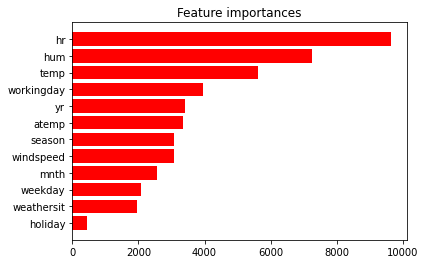

In [ ]:
plot_importance(reg)

According to the plot, the most important feature are hr, hum and temp.

# Time Series Split

In [ ]:
df = df.set_index('dteday')

In [ ]:
X_train, y_train = df[df['yr']==0][numerical + categorical].drop(['yr'], axis=1), df[df['yr']==0][target]
X_test, y_test = df[df['yr']==1][numerical + categorical].drop(['yr'], axis=1), df[df['yr']==1][target]
cas_train, cas_test = df[df['yr']==0]['casual'], df[df['yr']==1]['casual']
reg_train, reg_test = df[df['yr']==0]['registered'], df[df['yr']==1]['registered']

In [ ]:
reg = LGBMRegressor(**{'boosting_type': 'dart', 'learning_rate': 0.2036, 'n_estimators': 1450, 'num_leaves': 33})
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
lgb_mae = mean_absolute_error(y_test, y_pred)
lgb_r2 = r2_score(y_test,  y_pred)
print('MAE: ', lgb_mae)
print('R2: ', lgb_r2)

MAE:  90.016531333585
R2:  0.637317044280053


We can see, that the error is bigger than using shuffle split. It seems that we got a data leak, than used shuffle. We use information from future to predict the previous values. Also, as we seen before, average target value is higher in 2012, and when we train the model on the previous year, we get biased estimates.

Let's try to roughly get rid of bias, using the difference between standard deviations between 2 years.

In [ ]:
df[df['yr'] == 0][target].mean(), df[df['yr'] == 1][target].mean()

(143.79444765760556, 234.6663613464621)

In [ ]:
(df[df['yr'] == 0][target].std(), df[df['yr'] == 1][target].std())

(133.79785413838638, 208.91094098639914)

In [ ]:
coef = df[df['yr'] == 1][target].std()/df[df['yr'] == 0][target].std()
coef

1.5613923132901946

In [ ]:
lgb_mae = mean_absolute_error(y_test, coef*y_pred)
lgb_r2 = r2_score(y_test,  coef*y_pred)
print('MAE: ', lgb_mae)
print('R2: ', lgb_r2)

MAE:  39.6347545758329
R2:  0.9111788032436907


We can see, that having applied such a simple transformation we significantly reduced error.

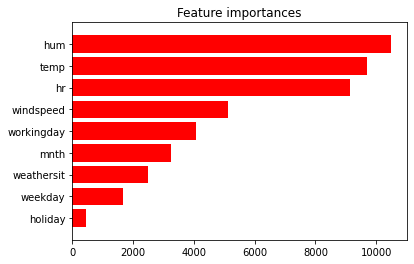

In [ ]:
plot_importance(reg)

# Multitarget regression

Registered and casual show different types of relationship with predictors. So, we should train models independently, because hyperparameters may be different.

**Casual**

In [ ]:
coef_cas = df[df['yr'] == 1]['casual'].std()/df[df['yr'] == 0]['casual'].std()
coef_reg = df[df['yr'] == 1]['registered'].std()/df[df['yr'] == 0]['registered'].std()
coef_cas, coef_reg 

(1.4667676725912513, 1.6031427954163635)

In [ ]:
lgb_reg_params ={
    'num_leaves' : hp.choice('num_leaves', np.arange(2, 40, dtype=int)),
    'n_estimators' : hp.choice('n_estimators', range(50, 3000, 50)),
    'boosting_type' :  hp.choice('boosting_type', ['dart', 'gbdt']),
    'learning_rate' :  hp.quniform('learning_rate', 0.0001, 0.5, 0.0001),
}
cv = TimeSeriesSplit(n_splits=5)

def hyperopt_lgbm_score(params):
    reg = LGBMRegressor(**params)
    current_score = cross_val_score(reg, X_train, cas_train, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1).mean()
    print(current_score, params)
    return -current_score


lgb_best = fmin(fn=hyperopt_lgbm_score, space=lgb_reg_params, algo=tpe.suggest, max_evals=50)

-13.332483620373575
{'boosting_type': 'gbdt', 'learning_rate': 0.0689, 'n_estimators': 1000, 'num_leaves': 28}
-13.904022088806078
{'boosting_type': 'gbdt', 'learning_rate': 0.3057, 'n_estimators': 350, 'num_leaves': 39}
-15.281964136335779
{'boosting_type': 'gbdt', 'learning_rate': 0.4985, 'n_estimators': 2150, 'num_leaves': 34}
-13.229937446740006
{'boosting_type': 'dart', 'learning_rate': 0.40690000000000004, 'n_estimators': 200, 'num_leaves': 34}
-12.536065277991018
{'boosting_type': 'dart', 'learning_rate': 0.18430000000000002, 'n_estimators': 1650, 'num_leaves': 7}
-13.105704474457179
{'boosting_type': 'dart', 'learning_rate': 0.37770000000000004, 'n_estimators': 2450, 'num_leaves': 21}
-12.527713180040154
{'boosting_type': 'dart', 'learning_rate': 0.2054, 'n_estimators': 1150, 'num_leaves': 8}
-15.902825290625435
{'boosting_type': 'gbdt', 'learning_rate': 0.2939, 'n_estimators': 1600, 'num_leaves': 3}
-12.932998997353067
{'boosting_type': 'dart', 'learning_rate': 0.3262, 'n_esti

In [ ]:
reg_cas = LGBMRegressor(**{'boosting_type': 'dart', 'learning_rate': 0.1519, 'n_estimators': 1800, 'num_leaves': 11})
reg_cas.fit(X_train, cas_train)
cas_pred = reg_cas.predict(X_test)
lgb_mae = mean_absolute_error(cas_test, cas_pred)
lgb_r2 = r2_score(cas_test, cas_pred)
print('MAE: ', lgb_mae)
print('R2: ', lgb_r2)

MAE:  15.55079002112695
R2:  0.75385664508437


In [ ]:
lgb_mae = mean_absolute_error(cas_test, coef_cas*cas_pred)
lgb_r2 = r2_score(cas_test, coef_cas*cas_pred)
print('MAE: ', lgb_mae)
print('R2: ', lgb_r2)

MAE:  12.2137580771232
R2:  0.8666074516273609


In [ ]:
lgb_reg_params ={
    'num_leaves' : hp.choice('num_leaves', np.arange(2, 40, dtype=int)),
    'n_estimators' : hp.choice('n_estimators', range(50, 3000, 50)),
    'boosting_type' :  hp.choice('boosting_type', ['dart', 'gbdt']),
    'learning_rate' :  hp.quniform('learning_rate', 0.0001, 0.5, 0.0001),
}
cv = TimeSeriesSplit(n_splits=5)

def hyperopt_lgbm_score(params):
    reg = LGBMRegressor(**params)
    current_score = cross_val_score(reg, X_train, reg_train, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1).mean()
    print(current_score, params)
    return -current_score


lgb_best = fmin(fn=hyperopt_lgbm_score, space=lgb_reg_params, algo=tpe.suggest, max_evals=50)

-45.58450663621125
{'boosting_type': 'dart', 'learning_rate': 0.0926, 'n_estimators': 200, 'num_leaves': 3}
-30.603223384308897
{'boosting_type': 'dart', 'learning_rate': 0.1938, 'n_estimators': 850, 'num_leaves': 27}
-30.92849389469212
{'boosting_type': 'dart', 'learning_rate': 0.43260000000000004, 'n_estimators': 2800, 'num_leaves': 36}
-34.90722788202214
{'boosting_type': 'gbdt', 'learning_rate': 0.41200000000000003, 'n_estimators': 100, 'num_leaves': 15}
-31.88291260794661
{'boosting_type': 'gbdt', 'learning_rate': 0.044500000000000005, 'n_estimators': 1000, 'num_leaves': 18}
-31.816923777067082
{'boosting_type': 'gbdt', 'learning_rate': 0.0806, 'n_estimators': 900, 'num_leaves': 16}
-31.395811389300217
{'boosting_type': 'dart', 'learning_rate': 0.3135, 'n_estimators': 1100, 'num_leaves': 8}
-31.568380052195828
{'boosting_type': 'dart', 'learning_rate': 0.29200000000000004, 'n_estimators': 200, 'num_leaves': 10}
-30.943863834654895
{'boosting_type': 'dart', 'learning_rate': 0.24810

In [ ]:
reg_reg = LGBMRegressor(**{'boosting_type': 'dart', 'learning_rate': 0.1938, 'n_estimators': 850, 'num_leaves': 27})
reg_reg.fit(X_train, reg_train)
reg_pred = reg_reg.predict(X_test)
lgb_mae = mean_absolute_error(reg_test, reg_pred)
lgb_r2 = r2_score(reg_test, reg_pred)
print('MAE: ', lgb_mae)
print('R2: ', lgb_r2)

MAE:  76.88208054867857
R2:  0.6166988209918787


In [ ]:
lgb_mae = mean_absolute_error(reg_test, coef_reg*reg_pred)
lgb_r2 = r2_score(reg_test, coef_reg*reg_pred)
print('MAE: ', lgb_mae)
print('R2: ', lgb_r2)

MAE:  33.13900840154303
R2:  0.9102771700330781


In [ ]:
y_pred = coef_reg*reg_pred + coef_cas*cas_pred
lgb_mae = mean_absolute_error(y_test, y_pred)
lgb_r2 = r2_score(y_test, y_pred)
print('MAE: ', lgb_mae)
print('R2: ', lgb_r2)

MAE:  38.83987797416449
R2:  0.9144054639448814


So, we got some better results for multitarget regression. It is connected to that casual and registered are connected to predictors differently, and different hyperparameters can help us to predict 

Also we know, that our target is descrete. We can try to round the predicted values.

In [ ]:
y_pred = coef_reg*reg_pred + coef_cas*cas_pred
lgb_mae = mean_absolute_error(y_test, np.round(y_pred))
lgb_r2 = r2_score(y_test, np.round(y_pred))
print('MAE: ', lgb_mae)
print('R2: ', lgb_r2)

MAE:  38.83913441722006
R2:  0.9143975776325599


We can see, that the result is almost the same.

We have two targets, so we need to analyze feature importance separetly.

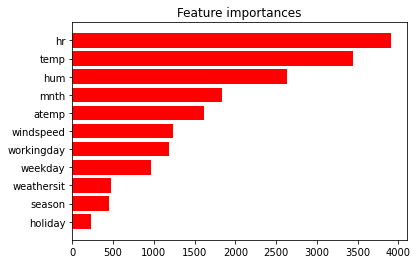

In [ ]:
plot_importance(reg_cas)

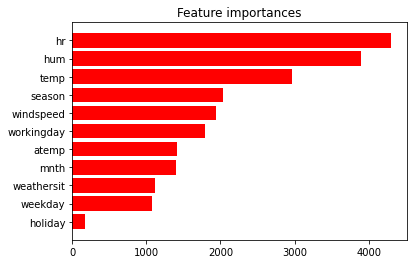

In [ ]:
plot_importance(reg_reg)

Some insights:
* According to the trained models, hour is the most significant feature.
* Temp and hum also are in the top 3, but take different positions for different models.
* Holiday is the least important feature.
* We can see, that month and season take different position in feature importance list for different targets. Season is more important for registered, month is more impotant for casual.
* According to our models, hour is more important than season, temp is more important than atemp. In case of hour we have a brigt relationship with casual and registered. In case of temp it is quite difficult to tell, what is the reason. As we could see previously, temp and atemp are very correlated. Probably, temp contains some more information about target.